In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import simos as sos
import qutip as qu
import scipy as sc

# Basic demonstration of the Fokker-Planck module

In this example, we show-case how to use the Fokker-Planck formalism to simulate the dynamics of a simple two-spin system.

In [ ]:
I = {'val': 1/2, 'name':'I'} 
J = {'val': 1/2 , 'name':'J'}
s = sos.System([I,J], method = "qutip")

The two spins are coupled to each other via a dipolar coupling.

In [ ]:
theta = np.deg2rad(10)
phi  = np.deg2rad(5)
Hdip = sos.dipolar_coupling(s, "I", "J", sos.yH1, sos.yF19, np.array([3e-10, theta, phi]), mode = "spher", approx = "secular")

Just to verify that the coupling is working, we start with one of the spins fully polarized in the z-direction, and the other spin fully unpolarized.

In [ ]:
dt =  3e-6
U = sos.evol(Hdip, dt)

rho0 = sos.tensor([sos.pol_spin(1), sos.pol_spin(0)])
rho = sos.rot((s.Ix), np.pi/2, rho0)

store = []
for i in range(1000):
    rho = U*rho*U.dag() 
    meas = sos.expect((s.Ix+1j*s.Iy), rho)
    store.append(meas)

(-50000.0, 50000.0)

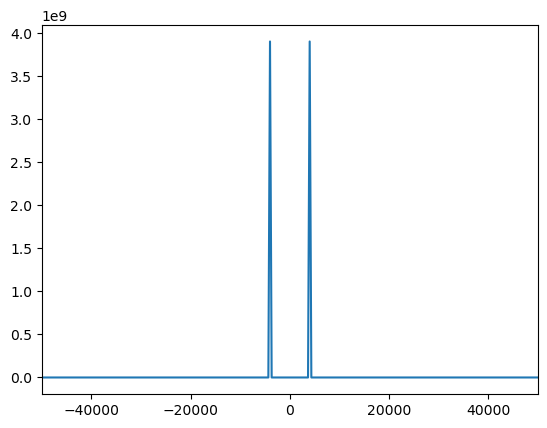

In [ ]:
fax,fft = sos.ffthelper(store,dt,dc_block=True,real_input=False)
plt.plot(fax,np.abs(fft)**2)

plt.xlim([-50e3,50e3])

As expected, we observe a splitting of the NMR signal of the fully polarized spin.

## Powder-averaged dipolar coupling

To simulate the powder-average, we need to parametrize the dipolar coupling in terms of the $\theta$ angle. For this, we write a function that takes the $\theta$ angle as input and returns the dipolar coupling Hamiltonian.

In [ ]:
def H_fun(theta):
    Hdip = sos.dipolar_coupling(s, "I", "J", sos.yH1, sos.yF19, np.array([3e-10, theta, phi]), mode = "spher", approx = "secular")
    return Hdip

We can now initialize the `StochasticLiouvilleParameters` object that holds the parameter values for the $\theta$ angle. We exapnd to a Fokker-Planck-space that uses 100 $\theta$ angles. Note that we need to adjust the weights to account for the fact that the $\theta$ angles are not uniformly distributed. Older approaches use e.g. Lebedev grids to cope with this. As we do not have dynamic information, we set the `dynamics` parameter to only one entry with the key `0`. Alternatively, we could have used the `dynamics` parameter set to `None`.

In [ ]:
params = sos.StochasticLiouvilleParameters()
params["theta"].values = np.linspace(0, np.pi, 100)
params["theta"].dynamics = {0:1}
params["theta"].weights = np.sin(params["theta"].values)

Finally, we can simulate the dynamics of the two-spin system using the Fokker-Planck formalism. We use the `stochastic_evol` routine to solve the Fokker-Planck equation. We convert the initial state to the Fokker-Planck space using the `dm2fp` method. Furthermore, we cache the propagator for imrpoved performance.

In [ ]:
rho0 = sos.tensor([sos.pol_spin(1), sos.pol_spin(0)])

rho = sos.rot((s.Ix), np.pi/2, rho0)
rhotmp = sos.dm2fp(rho, params.dof,try_ket=False)
U =  sos.stochastic_evol(H_fun, params, dt, method='qutip',space='liouville',c_ops=[0*s.Iz])

In [ ]:
store = []
for i in range(1000):
    rhotmp =  U*rhotmp
    rho = sos.fp2dm(rhotmp,is_hilbert=False,dims=s.dims,weights=params.tensor_weights())
    meas = sos.expect((s.Ix+1j*s.Iy), rho)
    store.append(meas)

By performing a Fourier transform of the resulting trace, we observe the famous Pake doublet.

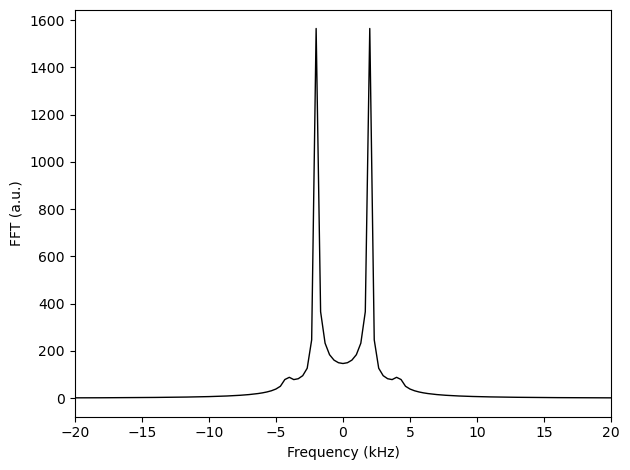

In [ ]:
fax, fft = sos.ffthelper(store,dt,dc_block=False,real_input=False,)
plt.plot(fax*1e-3,np.abs(fft),c='k',lw=1)
plt.xlim([-20,20])
plt.xlabel('Frequency (kHz)')
plt.ylabel('FFT (a.u.)')

plt.tight_layout()

## Magic Angle Spinning (MAS)

A commonly-used technique in solid-state NMR is magic angle spinning (MAS). This technique averages the dipolar coupling over the spinning angle $\theta$. In our case, we can simulate this by averaging the dipolar coupling over the $\theta$ angles. For this, the dynamics parameter is set. By setting its key `1` to $2\pi \times 100$ kHz, we simulate a MAS spinning at 100 kHz.

In [ ]:
params = sos.StochasticLiouvilleParameters()
params["phi"].values = np.linspace(0, np.pi, 100)
params["phi"].dynamics = {1:sos.f2w(100e3)}
params["phi"].weights = None

In [ ]:
def H_fun_MAS(phi):
    vec = sos.spher2cart(np.array([3e-10, 0, 0]))
    rotvec = phi*sos.mas_axis
    R = sc.spatial.transform.Rotation.from_rotvec(rotvec)

    Hdip = sos.dipolar_coupling(s, "I", "J", sos.yH1, sos.yF19, R.apply(vec), mode = "cart", approx = "secular")
    return Hdip 

In [ ]:
rho0 = sos.tensor([sos.pol_spin(1), sos.pol_spin(0)])

rho = sos.rot((s.Ix), np.pi/2, rho0)
rhotmp = sos.dm2fp(rho, params.dof,try_ket=False)
U =  sos.stochastic_evol(H_fun_MAS, params, dt, method='qutip',space='liouville',c_ops=[0*s.Iz])

In [ ]:
store = []
for i in sos.bar(range(1000)):
    rhotmp =  U*rhotmp
    rho = sos.fp2dm(rhotmp,is_hilbert=False,
                           dims=s.dims,weights=params.tensor_weights())
    meas = sos.expect((s.Ix+1j*s.Iy), rho)
    store.append(meas)

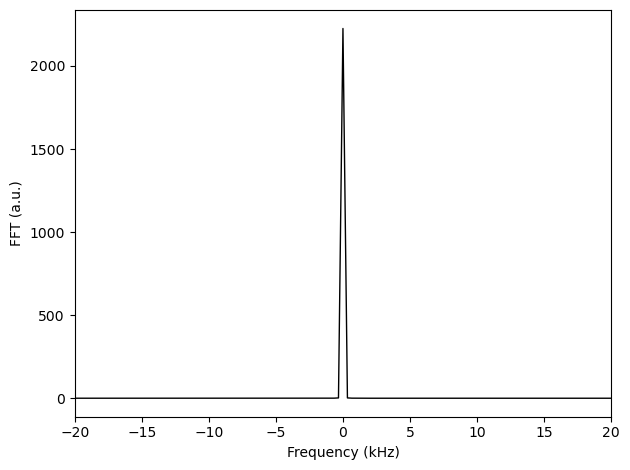

In [ ]:
fax, fft = sos.ffthelper(store,dt,dc_block=False,real_input=False,)
plt.plot(fax*1e-3,np.abs(fft)/100,c='k',lw=1)
plt.xlim([-20,20])
plt.xlabel('Frequency (kHz)')
plt.ylabel('FFT (a.u.)')

plt.tight_layout()

As expected, the Pake doublet is averaged out and we observe a single peak.